<a href="https://colab.research.google.com/github/dSatasiya/WLC-With-Machine-Learning/blob/Project-sem-8/NOMA_CNN_2_bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt

In [ ]:
np.random.seed(5)
N = 2
M = 2
n_iteration = 1
batch_size = 1

n_epoch = 10
modulation_order = 2

# -------------- Modification ----------------
# Considering the case of three dynamic users U1, U2 and U3.
# Where U1 is farthest user and U3 is located as nearest user 

pi = 3.14
f_c = 5.9*(pow(10, 9))   # carrier frequency 
C = 3*(pow(10, 8)) # m/s   
v = 15.277   # speed of vehicles in m/s
R_s = 10  # Transmission symbol rate in Mbps
# J_0 = # zeroth order bassel function of the first kind
rho_n = ((2*pi*f_c*v)/(R_s*C)) # is correlation parameter for time adjacent channel gain
print(rho_n)

 # Questions to be asked are :
 # 1) how to take J_0 which is bassel function ? 
 # 2) what about en(l) ?
 # 3) what about t ?
 
# e_n_of_l is time varying component 
# for the sake of simplicity let's say 
e_n_of_l = 1

dn =  2 # Distance between BS and nth vehicles
Hdn = 3 # Nakagami-m channel between BS and nth vehicle
epsilon = 3  # path loss 
def channel_generation(t):  # final channel formula
  channel_t = (Hdn)/(math.sqrt(1+ pow(dn, epsilon)))
  print(channel_t)
  part1 = pow(rho_n, (t-1))*channel_t 
  # print(part1)
  sqr = -(1 - pow(rho_n, 2))
  # print(sqr)
  part2 = math.sqrt(sqr)
  # print(part2)
  l = 1
  sum1 = 0
  for l in range(1, (t-1)+1):
    sum1 = sum1 + rho_n*(t - l - 1)* e_n_of_l
    
  channel = part1 + part2*sum1

  return channel
print(channel_generation(1))

# power coefficients for all users
Alpha_1 = 0.6
Alpha_2 = 0.27
Alpha_3 = 0.13
Ps = 1  # Transmission power 
# S_i = is Kx1 message signal vector of ith vehicle 

Alpha_values = [0.6, 0.27, 0.13]

# ----------------- Generation of final equation -----------------
def final_eqn():
  channel = channel_generation(1)
  no_of_users = 2
  sum2 = np.zeros(2)
  print(sum2)
  for i in range(1, no_of_users+1):
    SPC = generate(2, 2, 1)
    sum2 = sum2 + (math.sqrt(Ps*Alpha_values[i]))* SPC

  final_eq = channel*sum2
  return final_eq
print(final_eqn())

SNR_db = np.array(list(range(2, 11, 2)))
test_size = 100
# print(SNR_db)

ERROR_user1 = np.zeros([len(SNR_db), n_iteration])
ERROR_user2 = np.zeros([len(SNR_db), n_iteration])
# print(ERROR_user1)
# print(ERROR_user2)

188.68113466666668
1.0
1.0
1.0
[0. 0.]


TypeError: ignored

In [ ]:
# ---------------------------------- First Function ----------------------------
def generate_data(M, batch_size):
  input_ = [[0 for _ in range(pow(2, M))] for _ in range(M)]
  label = [[0 for _ in range(pow(2, M))] for _ in range(2 * M)]

  for i in range(1 << M):
      for j in range(M):
          if i & (1 << j):
              input_[M - j - 1][i] = 1
  for i in range(1 << M):
      for j in range(M):
          if input_[j][i] == 1:
              label[2 * j][i] = 1
              label[2 * j + 1][i] = 0
          else:
              label[2 * j][i] = 0
              label[2 * j + 1][i] = 1

  input_ = np.tile(np.array(input_), batch_size)
  label = np.tile(np.eye(1 << M), batch_size)
  return input_, label
generate_data(2, 1)


(array([[0, 0, 1, 1],
        [0, 1, 0, 1]]), array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]))

In [ ]:
# ---------------------------------- Second Function ----------------------------
def generate(M, N, batch_size):
  data, label = generate_data(M, batch_size)

  ran1 = np.random.permutation(batch_size * pow(2, M))  # Suffling Dataset
  ran2 = np.random.permutation(batch_size * pow(2, M))

  symbol1 = 2 * data[:, ran1] - 1       # BPSK is applied here
  symbol2 = 2 * data[:, ran2] - 1

  SPC = math.sqrt(0.8) * symbol1 + math.sqrt(0.2) * symbol2  # Superposition Coding

  label1 = np.transpose(label[:, ran1].astype('float32'))
  label2 = np.transpose(label[:, ran2].astype('float32'))

  return SPC, label1, label2

generate(2, 2, 1)

(array([[-0.4472136 , -1.34164079,  1.34164079,  0.4472136 ],
        [-0.4472136 ,  0.4472136 , -1.34164079,  1.34164079]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]], dtype=float32))

In [ ]:
# ---------------------------------- Third Function ----------------------------
def generate_input(H1_real, H1_image, SPC, N, batch_size, sigma):
  N_real, N_image = generate_channel(N, batch_size * pow(2, N), 0)

  input1_real = np.matmul(H1_real, SPC) + sigma * N_real
  input1_img = np.matmul(H1_image, SPC) + sigma * N_image

  input1 = np.transpose(np.concatenate((input1_real, input1_img), axis=0))

  return input1_real, input1_img

In [ ]:
# ---------------------------------- Four Function ----------------------------
def generate_channel(N, M, k):
  h1 = np.random.randn(N, M) / math.sqrt(2)
  h2 = np.random.randn(N, M) / math.sqrt(2)

  if k == 0:
      return h1, h2
  else:
      return 2 * h1, 2 * h2
generate_channel(2, 2, 0)

(array([[-0.01647824,  0.5952267 ],
        [ 0.967029  ,  0.4063797 ]]), array([[-1.33343539,  0.12086249],
        [-0.28503001,  1.15797821]]))

In [ ]:
def accuracy(output, label, M):

    correct_prediction = tf.equal(tf.math.argmax(output, 1), tf.math.argmax(label, 1))     # The tensor has not been sliced here
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))                          # But directly tf.math,argmax function has been applied
      
    return acc

In [ ]:
net = nn.Sequential(
    
    nn.Conv2d(1, 2, kernel_size=1, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=1, stride=1),                            # first convolution layer, then ReLU and the maxpooling will be performed

    nn.Conv2d(2, 2, kernel_size=1, padding=1), nn.ReLU(),       # second convolutional layer 
    nn.MaxPool2d(kernel_size=1, stride=1),                     # CNN has basically two layers : convolutional and fully connected(dense) layers 
                                                               # here, in our case 2 convolutional layers are there and othe below fully connected layers
                                                               # it will flatten the array into 1 dimension
    nn.Flatten(),                                   

    nn.BatchNorm1d(72),
    nn.Linear(72, 100), nn.ReLU(), nn.BatchNorm1d(100),
    nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100),
    nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100),
    nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100),
    nn.Linear(100, 4), nn.ReLU(), nn.BatchNorm1d(4)
)

loss = torch.nn.CrossEntropyLoss(reduction = 'mean')     #Cross Entropy Loss is used to find the loss (for logistic regression problem)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net1 = net.to(device = device)
net2 = net.to(device = device)
print(net1) 

Sequential(
  (0): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=72, out_features=100, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Linear(in_features=100, out_features=100, bias=True)
  (15): ReLU()
  (16): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): Linear(in_features=100, out

input_feature in conv2d function means that there will be this much no. channel.
in our case input_feature is = 1, means only gray-scale image.

output_feature means how many outputs will be there after the 1st convolution process, or in short number of filters in first hidden layers.

In [ ]:
H1_real, H1_image = generate_channel(N, M, 0)
H2_real, H2_image = generate_channel(N, M, 1)

cnt1 = 0

print('training iteration') 

H1_real, H1_image = generate_channel(N, M, 0)
H2_real, H2_image = generate_channel(N, M, 1)
for i in range(len(SNR_db)):
  # print('SNR : {}'.format(SNR_db[i]))
  for j in range(n_epoch):
    SPC, label1, _ = generate(M, N, batch_size)
    signal_power = np.mean(pow(SPC, 2))
    sigma_user1 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
    input1_train = generate_input(H1_real, H1_image, SPC, N, batch_size, sigma_user1)
                                  
    SPC, _, label2 = generate(M, N, batch_size )
    signal_power = np.mean(pow(SPC, 2))
    sigma_user2 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
    input2_train = generate_input(H2_real, H2_image, SPC, N, batch_size , sigma_user2)        

    input1_train = torch.Tensor(input1_train)
    label1_train = torch.Tensor(label1)
    input1 = torch.reshape(input1_train, (-1, 1, 2, 2))    # -1 will flaten the array and will also make 4x4 arrays 

    input2_train = torch.Tensor(input2_train)
    label2_train = torch.Tensor(label2)
    input2 = torch.reshape(input2_train, (-1, 1, 2, 2))
        
    # input1 = input1.cuda()
    label1 = label1_train
    # label1 = torch.cuda.LongTensor(label1)
    # input2 = input2.cuda()
    label2 = label2_train

    optimizer1 = optim.SGD(net1.parameters(), lr = 0.01)
    optimizer1.zero_grad()
    output1 = net1(input1)
    l1 = loss(output1, torch.max(label1, 1)[1])
    l1.backward()
    optimizer1.step()
    op1 = torch.Tensor.cpu(output1)
    out1 = op1.detach().numpy()
    acc1 = accuracy(out1, label1_train, M)
    cnt1 = cnt1+1
      
    output2 = net2(input2)
    optimizer2 = optim.SGD(net2.parameters(), lr = 0.01)
    optimizer2.zero_grad()
    l2 = loss(output2, torch.max(label2, 1)[1])
    l2.backward()
    optimizer2.step()  
    op2 = torch.Tensor.cpu(output2)
    out2 = op2.detach().numpy()
    acc2 = accuracy(out2, label2_train, M) 
    print("iter {}  : User1  {}  User2  {}".format(cnt1,acc1,acc2)) 


# ----------------------------------------- Extra Lines -------------------------------------

# H1_real, H1_image = generate_channel(2, 2, 0)
# N_real, N_image = generate_input(H1_real, H1_image, SPC, 2, batch_size, sigma_user1)
# input1_real, input1_img = generate_input(H1_real, H1_image, SPC, 2, batch_size, sigma_user1)


# label1 = torch.set_printoptions(profile = "full")
print(label1)
print(label1.shape)
# print(SPC)
# print(SPC.shape)
# print(f"Signal Power is : {signal_power}")
# print(f"The value of Sigma for User-1 is : {sigma_user1}")
print(input1)
print(input1.shape) 

# print(label2)
# print(f"Signal Power is : {signal_power}")
# print(f"The value of Sigma for User-2 is : {sigma_user2}")
# print(input2_train)
# print(label2.shape)
# print(input2_train.shape)

# print(input1_real)
# print(input1_real.shape) 
# print(input1_img)
# print(input1_img.shape) 

# input1 = torch.set_printoptions(profile= "full")
# input1 = torch.set_printoptions(profile= "default")
# print(f"---------Input to the nueral network -------- \n {input1}")
# print(input1.shape)
# output1 = torch.set_printoptions(profile= "full")
# output1 = torch.set_printoptions(profile= "default")
# print(f"---------Output to the nueral network -------- \n {output1}")
print(output1)
print(output1.shape)

# print(H1_real)
# print(H1_real.shape)
# print(H1_image)
# print(H1_image.shape)
# print(N_real)
# print(N_real.shape)
# print(N_image)
# print(N_image.shape)

# print(bit)

# --------------------- Special extra lines for loss function in CNN -------------
# SPC, label1, _ = generate(M, N, batch_size)
# label1_train = torch.Tensor(label1)
# label1 = label1_train 
# new_lab = torch.max(label1, 1)[1]
# print(label1)
# print(new_lab)


#-------------------------------------------------------------------------------------------

training iteration


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


iter 1  : User1  0.25  User2  0.5
iter 2  : User1  0.25  User2  0.0
iter 3  : User1  0.25  User2  0.25
iter 4  : User1  0.25  User2  0.25
iter 5  : User1  0.25  User2  0.25
iter 6  : User1  0.25  User2  0.25
iter 7  : User1  0.25  User2  0.25
iter 8  : User1  0.25  User2  0.25
iter 9  : User1  0.25  User2  0.25
iter 10  : User1  0.25  User2  0.25
iter 11  : User1  0.25  User2  0.25
iter 12  : User1  0.25  User2  0.25
iter 13  : User1  0.25  User2  0.25
iter 14  : User1  0.25  User2  0.25
iter 15  : User1  0.25  User2  0.25
iter 16  : User1  0.25  User2  0.25
iter 17  : User1  0.25  User2  0.25
iter 18  : User1  0.25  User2  0.25
iter 19  : User1  0.25  User2  0.25
iter 20  : User1  0.25  User2  0.25
iter 21  : User1  0.25  User2  0.25
iter 22  : User1  0.25  User2  0.25
iter 23  : User1  0.25  User2  0.25
iter 24  : User1  0.25  User2  0.25
iter 25  : User1  0.25  User2  0.25
iter 26  : User1  0.25  User2  0.25
iter 27  : User1  0.25  User2  0.25
iter 28  : User1  0.25  User2  0.25
ite

In [ ]:
# #------------------------Extra Block ------------------
# b = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]], dtype=torch.long)
# print(b)
# a = torch.reshape(b, (-1, 1, 2, 2))
# print(type(a))
# a = a.long()
# print(type(a))
# c = a.detach().numpy()
# print(c)
# print(type(c))
# print(c.shape)


# net = nn.Sequential(
    
    # nn.Conv2d(1, 2, kernel_size=1, stride=1, padding=1), nn.ReLU(),
    # nn.MaxPool2d(kernel_size=1, stride=1) 
# )

# output = net(a)
# # -----------------------End of the extra block ------------

In [ ]:
ERROR_user1 = np.zeros([len(SNR_db), 1])
ERROR_user2 = np.zeros([len(SNR_db), 1])
print(ERROR_user1)
print(ERROR_user2)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
for k in range(1):
  print('testing operation')
  for i in range(len(SNR_db)):

        SPC, label1_test, label2_test = generate(M, N, batch_size )
        signal_power = np.mean(pow(SPC, 2))
        sigma_test = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input1_test = generate_input(H1_real, H1_image, SPC, N, batch_size , sigma_test)
        input2_test = generate_input(H2_real, H2_image, SPC, N, batch_size , sigma_test)

        input1_test = torch.Tensor(input1_test)
        label1_test = torch.Tensor(label1_test)
        input1_test = torch.reshape(input1_test, [-1,1,2,2])

        # input1 = input1_test.cuda()
        # label1 = label1_test.cuda()

        input1 = input1_test
        label1 = label1_test

        testop1 = net1(input1)

        out1 = torch.Tensor.cpu(testop1)
        out1 = out1.detach().numpy()
        ac1 = accuracy(out1, label1_test, M) 
        
        ERROR_user1[i, k] = 1 - ac1

        input2_test = torch.Tensor(input2_test)
        label2_test = torch.Tensor(label2_test)
        input2_test = torch.reshape(input2_test, [-1,1,2,2])
        # input2 = input2_test.cuda()
        # label2 = label2_test.cuda()

        input2 = input2_test
        label2 = label2_test
        
        testop2 = net2(input2)
        opt2 = torch.Tensor.cpu(testop2)
        out2 = opt2.detach().numpy()
        ac2 = accuracy(out2, label2_test, M)
        ERROR_user2[i, k] = 1 - ac2

testing operation


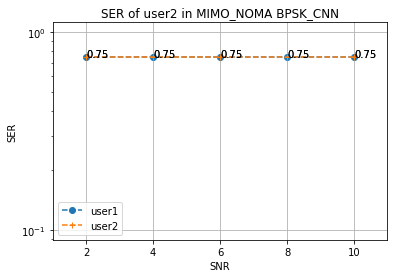

SNR : [ 2  4  6  8 10]
bit error for user 1 at testing : [0.75 0.75 0.75 0.75 0.75]
bit error for user 2 at testing : [0.75 0.75 0.75 0.75 0.75]


In [ ]:
error1 = np.mean((ERROR_user1), axis=1)
error2 = np.mean((ERROR_user2), axis=1)
# print(H1_real)
plt.figure()
plt.semilogy(SNR_db, error1, ls='--', marker='o', label='user1')
plt.semilogy(SNR_db, error2, ls='--', marker='+', label='user2')
for i in range(5):
  label1 = "{:.2f}".format(error1[i])
  label2 = "{:.2f}".format(error2[i])
  plt.annotate(label1,(SNR_db[i],ERROR_user1[i]))
  plt.annotate(label2,(SNR_db[i],ERROR_user2[i]))
plt.grid()
plt.legend()
plt.xlim(pow(10, 0), pow(11, 1))
plt.xlabel('SNR')
plt.ylabel('SER')
plt.title('SER of user2 in MIMO_NOMA BPSK_CNN')
plt.savefig('SER_MIMO_NOMA_CNN_BPSK')
plt.show()
print("SNR : {}".format(SNR_db))
print("bit error for user 1 at testing : {}".format(error1))
print("bit error for user 2 at testing : {}".format(error2))